# Load Data

In [1]:
from data import get_mnist_dataloaders

from diffusion.transition import (
    linear_beta_schedule,
    build_all_transition_matrices,
    compute_cumulative_transition_matrices,
    sample_q_xt_given_x0,
    compute_discrete_posterior
)

from models.simple_mlp import SimpleD3PMMLP
from diffusion.transition import sample_q_xt_given_x0, compute_discrete_posterior
from diffusion.reverse import compute_p_theta_xtminus1_given_xt_from_p_tilde
from training.train_one_epoch import train_one_epoch

import torch
import torch.nn.functional as F

In [2]:
device = 'cuda'

In [3]:
train_loader, test_loader = get_mnist_dataloaders(
    batch_size=32,
    train_subset_size=1000,
    test_subset_size=200,
    data_root="./data",
    threshold=0.5
)

In [4]:
# Shape is (batch_size, channels, height, width)
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [5]:
# Black or white pixels rather than greyscale
print(torch.unique(x))

tensor([0, 1])


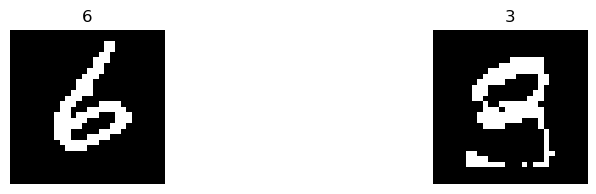

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 2))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(x[i].squeeze(), cmap="gray", vmin=0, vmax=1)
    plt.title(y[i].item())
    plt.axis("off")
plt.show()

# Define Transition Matrix for noising

In [7]:
T = 100

betas = linear_beta_schedule(T).to(device)
Qs = build_all_transition_matrices(betas).to(device)

print(betas.shape)   # torch.Size([100])
print(Qs.shape)      # torch.Size([100, 2, 2])
print(Qs[0])
print(Qs[T-1])

torch.Size([100])
torch.Size([100, 2, 2])
tensor([[9.9990e-01, 1.0000e-04],
        [1.0000e-04, 9.9990e-01]], device='cuda:0')
tensor([[0.5000, 0.5000],
        [0.5000, 0.5000]], device='cuda:0')


In [8]:
# Define Qbar[t] = Q_1 * Q_2 * ... * Q_t
Qbar = compute_cumulative_transition_matrices(Qs, device=device)   # [T,2,2]

In [9]:
print("Qbar[2]:\n", Qbar[1])
print("Qbar[T]:\n", Qbar[T-1])

Qbar[2]:
 tensor([[0.9948, 0.0052],
        [0.0052, 0.9948]], device='cuda:0')
Qbar[T]:
 tensor([[0.5000, 0.5000],
        [0.5000, 0.5000]], device='cuda:0')


# Noise Data and Visualise

In [10]:
x[0].shape

torch.Size([1, 28, 28])

In [11]:
timesteps = [0, 5, 10, 20, 40, 80, T-1]

results = []   # list of [(t, x_t_batch)]

for t in timesteps:
    xt_batch = sample_q_xt_given_x0(x, t=t, Qbar=Qbar)
    results.append((t, xt_batch.cpu()))

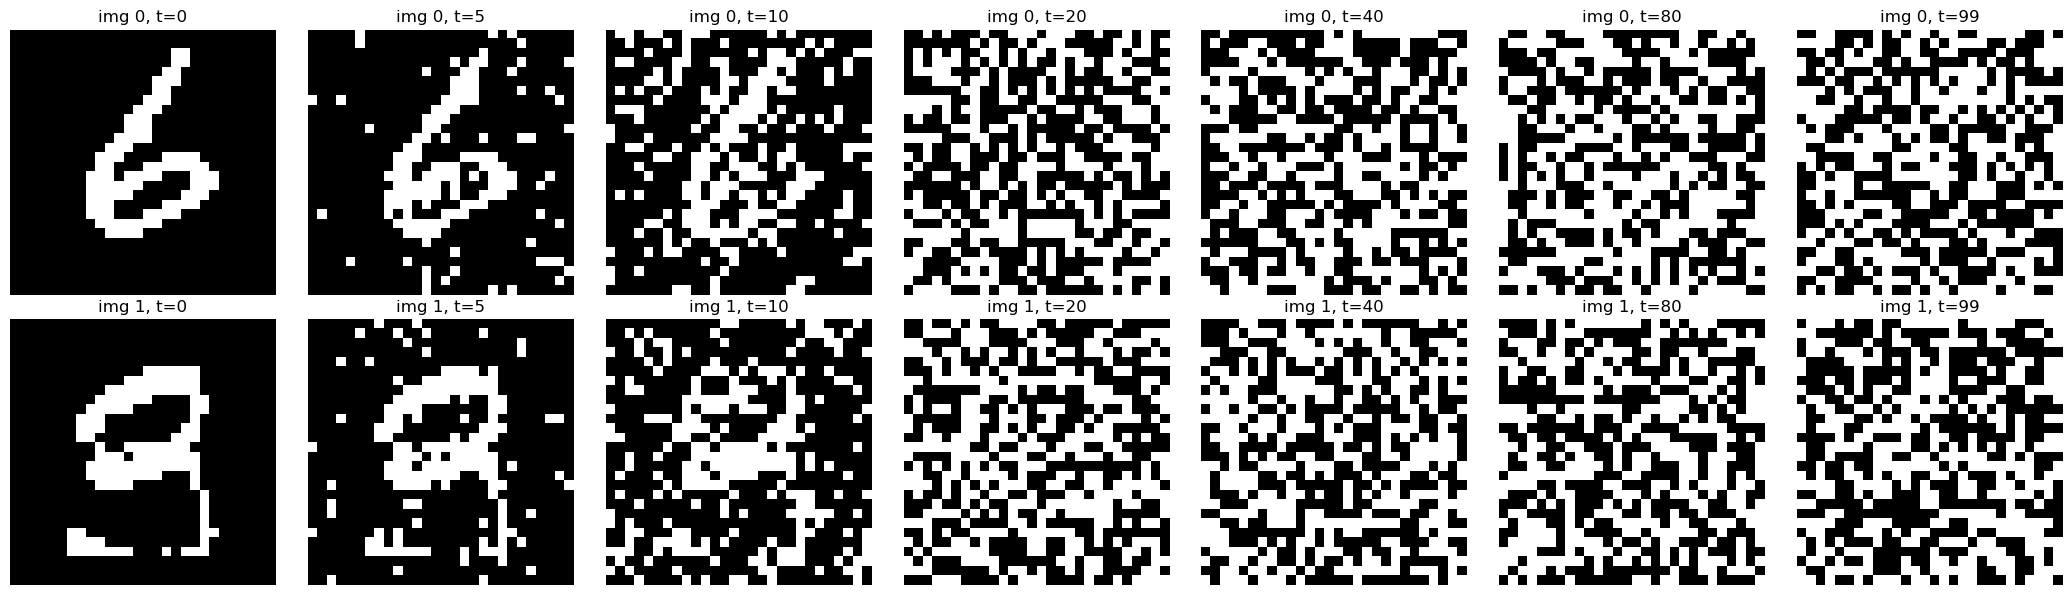

In [12]:
num_images = 2       # = 2
num_steps = len(timesteps)

plt.figure(figsize=(3 * num_steps, 3 * num_images))

for img_idx in range(num_images):  # loop over images in the batch
    for step_idx, (t, xt_batch) in enumerate(results):
        plt.subplot(num_images, num_steps, img_idx * num_steps + step_idx + 1)
        plt.imshow(xt_batch[img_idx].squeeze(), cmap="gray", vmin=0, vmax=1)
        plt.title(f"img {img_idx}, t={t}")
        plt.axis("off")

plt.tight_layout()
plt.show()

In [13]:
# Compute posterior Q(x_{t-1} | x_t, x_0) for t=99
t = 30   # random example
xt = sample_q_xt_given_x0(x, t=t, Qbar=Qbar)


q_posterior = compute_discrete_posterior(xt, x, t=t, Qs=Qs, Qbar=Qbar)

In [14]:
q_posterior.shape # (batch_size, channels, height, width, num_classes)

torch.Size([32, 1, 28, 28, 2])

In [15]:
# Example: get posterior distribution at pixel (2, 2) of first image in batch
q_posterior[0, 0, 2, 2]

tensor([0.8503, 0.1497], device='cuda:0')

# Initialize model to predict posterior

In [16]:
model = SimpleD3PMMLP(T=T).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [17]:
x = x.to(device)
t = torch.randint(1, T, (x.shape[0],), device=device)   # shape [B]

In [18]:
xt = sample_q_xt_given_x0(x, t, Qbar).to(device)        # [B,1,28,28]

In [19]:
# this is p̃_theta(x0 | x_t))
logits_x0 = model(xt, t).to(device)

In [20]:
# compute eqn (4)
p_theta = compute_p_theta_xtminus1_given_xt_from_p_tilde(logits_x0, xt, t, Qs, Qbar)   

In [21]:
# KL divergence between q_posterior and p_theta
log_q = torch.log(q_posterior + 1e-20)
log_p = torch.log(p_theta + 1e-20)
kl = (q_posterior * (log_q - log_p)).sum(dim=-1).mean()

In [22]:
# auxilary term is CE
p_tilde = F.softmax(logits_x0, dim=1).to(device)         # [B,2,28,28]
p_x0 = p_tilde.gather(1, x)                  # [B,1,28,28]
aux_ce = -(torch.log(p_x0 + 1e-20)).mean()

In [23]:
lambda_aux = 0.1  # (arbitraty)
loss = kl + lambda_aux * aux_ce

loss

tensor(0.7011, device='cuda:0', grad_fn=<AddBackward0>)

In [24]:
# ----- 10. Backprop + optimizer step -----
optimizer.zero_grad()
loss.backward()
optimizer.step()

print(f"loss={loss.item():.4f}, kl={kl.item():.4f}, aux_ce={aux_ce.item():.4f}, t_mean={t.float().mean().item():.1f}")

loss=0.7011, kl=0.6307, aux_ce=0.7041, t_mean=45.2


In [25]:
# Training Loop instead of step by step:
epochs=2
for epoch in range(epochs):
    stats = train_one_epoch(model, optimizer, train_loader, Qs, Qbar, T, device)
    print(f"Epoch {epoch}: {stats}")

Epoch 0: {'loss': 0.004530556583631551, 'kl': 0.004133140380872646, 'aux_ce': 0.3974161818623543, 'steps': 32}
Epoch 1: {'loss': 0.0030761075613554567, 'kl': 0.0027804558932302825, 'aux_ce': 0.29565166775137186, 'steps': 32}
